#### PSF convolution


Andressa Wille


andressaw2@gmail.com


28/01/2026

* This is a tutorial for plotting and convolving PSFs. Important functions are in psf.py.

In [2]:
import os
import glob
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve_fft
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
import re
from psf import *

Visualize PSF shapes: Here we are using the ePSFs made for Abell 2744 by the UNCOVER team.

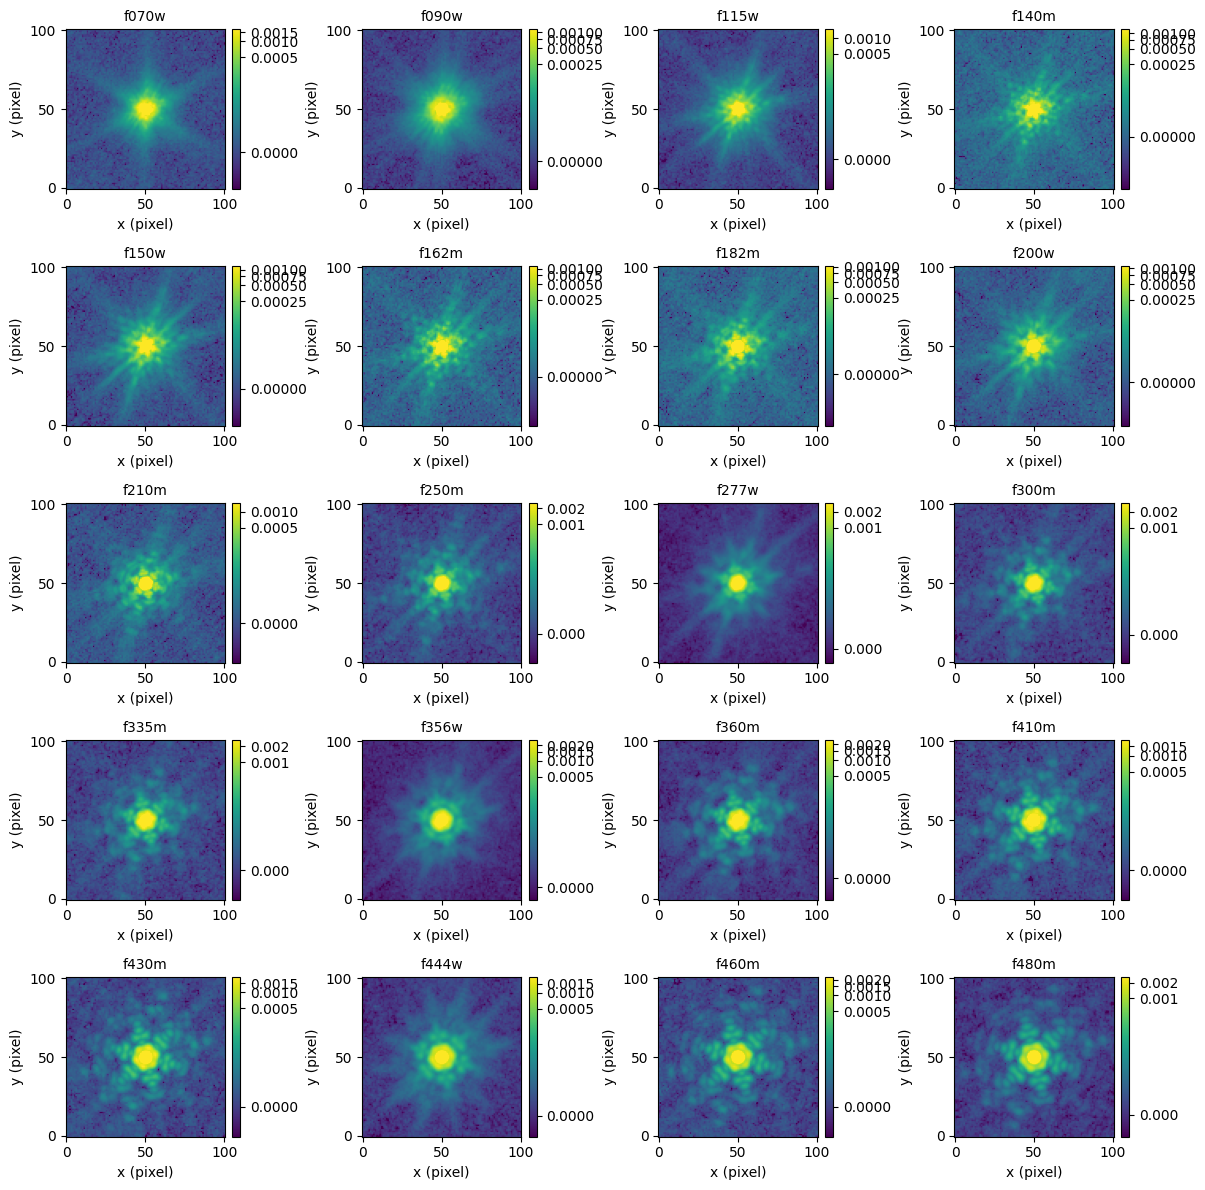

In [29]:
psf_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst"
psf_files = sorted(glob.glob(f"{psf_dir}/*.fits"))

n_filters = 20
ncols = 4
nrows = 5  
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
axes = axes.flatten()

for ax, psf_file in zip(axes, psf_files):
    with fits.open(psf_file) as hdul:
        ext = find_ext(hdul)
        if ext is None:
            raise ValueError(f"No valid image data in '{psf_file}'.")
        
        psf_data = hdul[ext].data
    
    filt_name = psf_file.split('/')[-1].replace('.fits', '')

    norm1 = simple_norm(psf_data, "log", percent=99.)
    # norm_mask = np.logical_or(np.isnan(psf_data), psf_data <= 0.)
    # norm2 = simple_norm(psf_data[~norm_mask], stretch="log", min_percent=25.,
    #                     max_percent=99.98)
    im = ax.imshow(psf_data, norm=norm1, origin="lower", cmap="viridis")
    
    ax.set_title(filt_name, fontsize=10)
    ax.set_xticks([0, 50, 100])
    ax.set_yticks([0, 50, 100])
    ax.set_xlabel("x (pixel)")
    ax.set_ylabel("y (pixel)")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


for j in range(n_filters, len(axes)):
    axes[j].axis("off")
    
plt.tight_layout()
#plt.savefig('abell2744_psf.png', dpi=200)
plt.show()

Build kernels:

In [8]:
psf_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst"
psf_files = sorted(glob.glob(f"{psf_dir}/*.fits"))

ref_psf_name = "f444w"
ref_psf_file = None

# find reference PSF
for f in psf_files:
    if ref_psf_name in os.path.basename(f):
        ref_psf_file = f
        break

if ref_psf_file is None:
    raise ValueError(f"Reference PSF {ref_psf_name} not found.")

print(f"Reference PSF: {ref_psf_file}")

with fits.open(ref_psf_file) as hdul:
    psf_ref = hdul[0].data

kernel_dir = os.path.join(psf_dir, "kernels_fft")
os.makedirs(kernel_dir, exist_ok=True)

for psf_file in psf_files:
    fname = os.path.basename(psf_file)

    # skip reference itself
    if psf_file == ref_psf_file:
        continue

    print(f"Building kernel: {fname} → {ref_psf_name}")

    # read source PSF
    with fits.open(psf_file) as hdul:
        psf_src = hdul[0].data
        header = hdul[0].header.copy()

    shape = psf_ref.shape

    # build kernel
    kernel = build_kernel(psf_src, psf_ref, shape, eps=5e-2) # you can change the eps value

    base = os.path.splitext(fname)[0]
    kernel_name = f"kernel_{base}_to_{ref_psf_name}.fits"
    kernel_path = os.path.join(kernel_dir, kernel_name)

    k_header = fits.Header()
    k_header["SRCPSF"] = base
    k_header["TGTPSF"] = ref_psf_name

    save_kernel(kernel, kernel_path, header=k_header)

Reference PSF: /home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/f444w.fits
Building kernel: f070w.fits → f444w
Kernel saved at /home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft/kernel_f070w_to_f444w.fits
Building kernel: f090w.fits → f444w
Kernel saved at /home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft/kernel_f090w_to_f444w.fits
Building kernel: f115w.fits → f444w
Kernel saved at /home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft/kernel_f115w_to_f444w.fits
Building kernel: f140m.fits → f444w
Kernel saved at /home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft/kernel_f140m_to_f444w.fits
Building kernel: f150w.fits → f444w
Kernel saved at /home/andressa/Doutorado/Pesquisa/clumps_ge

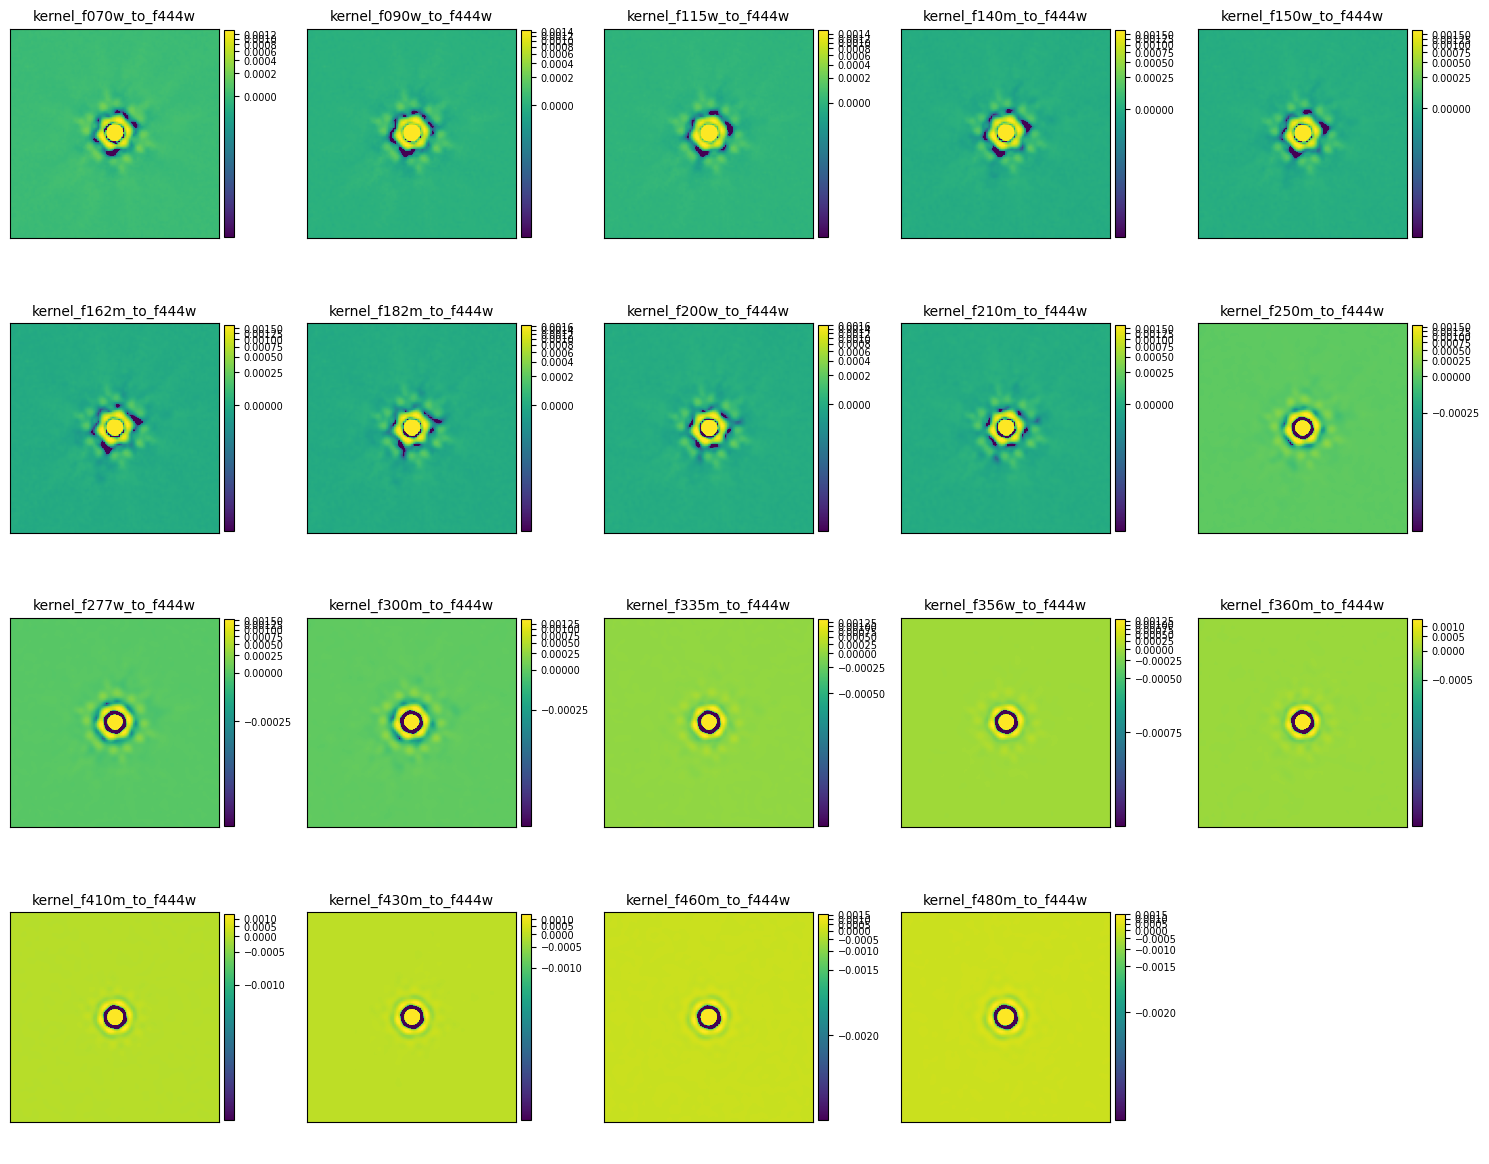

In [9]:
kernel_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft/"
kernel_files = sorted(glob.glob(f"{kernel_dir}/*.fits"))

n_filters = 20
ncols = 5
nrows = 4  
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
axes = axes.flatten()

for ax, kernel_file in zip(axes, kernel_files):
    with fits.open(kernel_file) as hdul:
        kernel_data = hdul[0].data
    
    filt_name = kernel_file.split('/')[-1].replace('.fits', '')

    norm1 = simple_norm(kernel_data, "log", percent=99.)
    # norm_mask = np.logical_or(np.isnan(kernel_data), kernel_data <= 0.)
    # norm2 = simple_norm(kernel_data[~norm_mask], stretch="log", min_percent=25.,
    #                     max_percent=99.98)
    im = ax.imshow(kernel_data, norm=norm1, origin="lower", cmap="viridis")
    ax.set_title(filt_name, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=7)

for j in range(len(kernel_files), len(axes)):
    axes[j].axis("off")
    
plt.tight_layout()
#plt.savefig('abell2744_kernel.png', dpi=200)
plt.show()

PSF matching (in individual filters)

In [10]:
path_fits = '/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/'
fits_files = sorted(glob.glob(f"{path_fits}/*_aligned.fits"))
kernel_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft"

In [11]:
for fpath in fits_files:
    fname = os.path.basename(fpath)
    filt  = get_filter(fname)

    if filt.upper() == "F444W":
        print(f"{filt} is reference filter, copying.")
        continue

    filt_lower = filt.lower()
    kernel_path = os.path.join(kernel_dir,
                               f"kernel_{filt_lower}_to_f444w.fits")

    if not os.path.exists(kernel_path):
        print(f"Kernel not found for {filt}, skipping.")
        continue

    print(f"Convolving {filt} using {os.path.basename(kernel_path)}")

    with fits.open(fpath) as hdul_img:
        img = hdul_img[0].data
        hdr = hdul_img[0].header

    with fits.open(kernel_path) as hdul_k:
        kernel = hdul_k[0].data

    img_conv = convolve_fft(img, kernel, allow_huge=True, normalize_kernel=True)

    out_name = fpath.replace("_aligned.fits", "_psfmatched.fits")
    fits.writeto(out_name, img_conv, hdr, overwrite=True)
    print(f"Saved at {out_name}")

Convolving F070W using kernel_f070w_to_f444w.fits
Saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F070W_psfmatched.fits
Convolving F090W using kernel_f090w_to_f444w.fits
Saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F090W_psfmatched.fits
Convolving F115W using kernel_f115w_to_f444w.fits
Saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F115W_psfmatched.fits
Convolving F140M using kernel_f140m_to_f444w.fits
Saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F140M_psfmatched.fits
Convolving F150W using kernel_f150w_to_f444w.fits
Saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F150W_psfmatched.fits
Convolving F162M using kernel_f162m_to_f444w.fits
Saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/F162M_psfmatched.fits
Convolving F182M

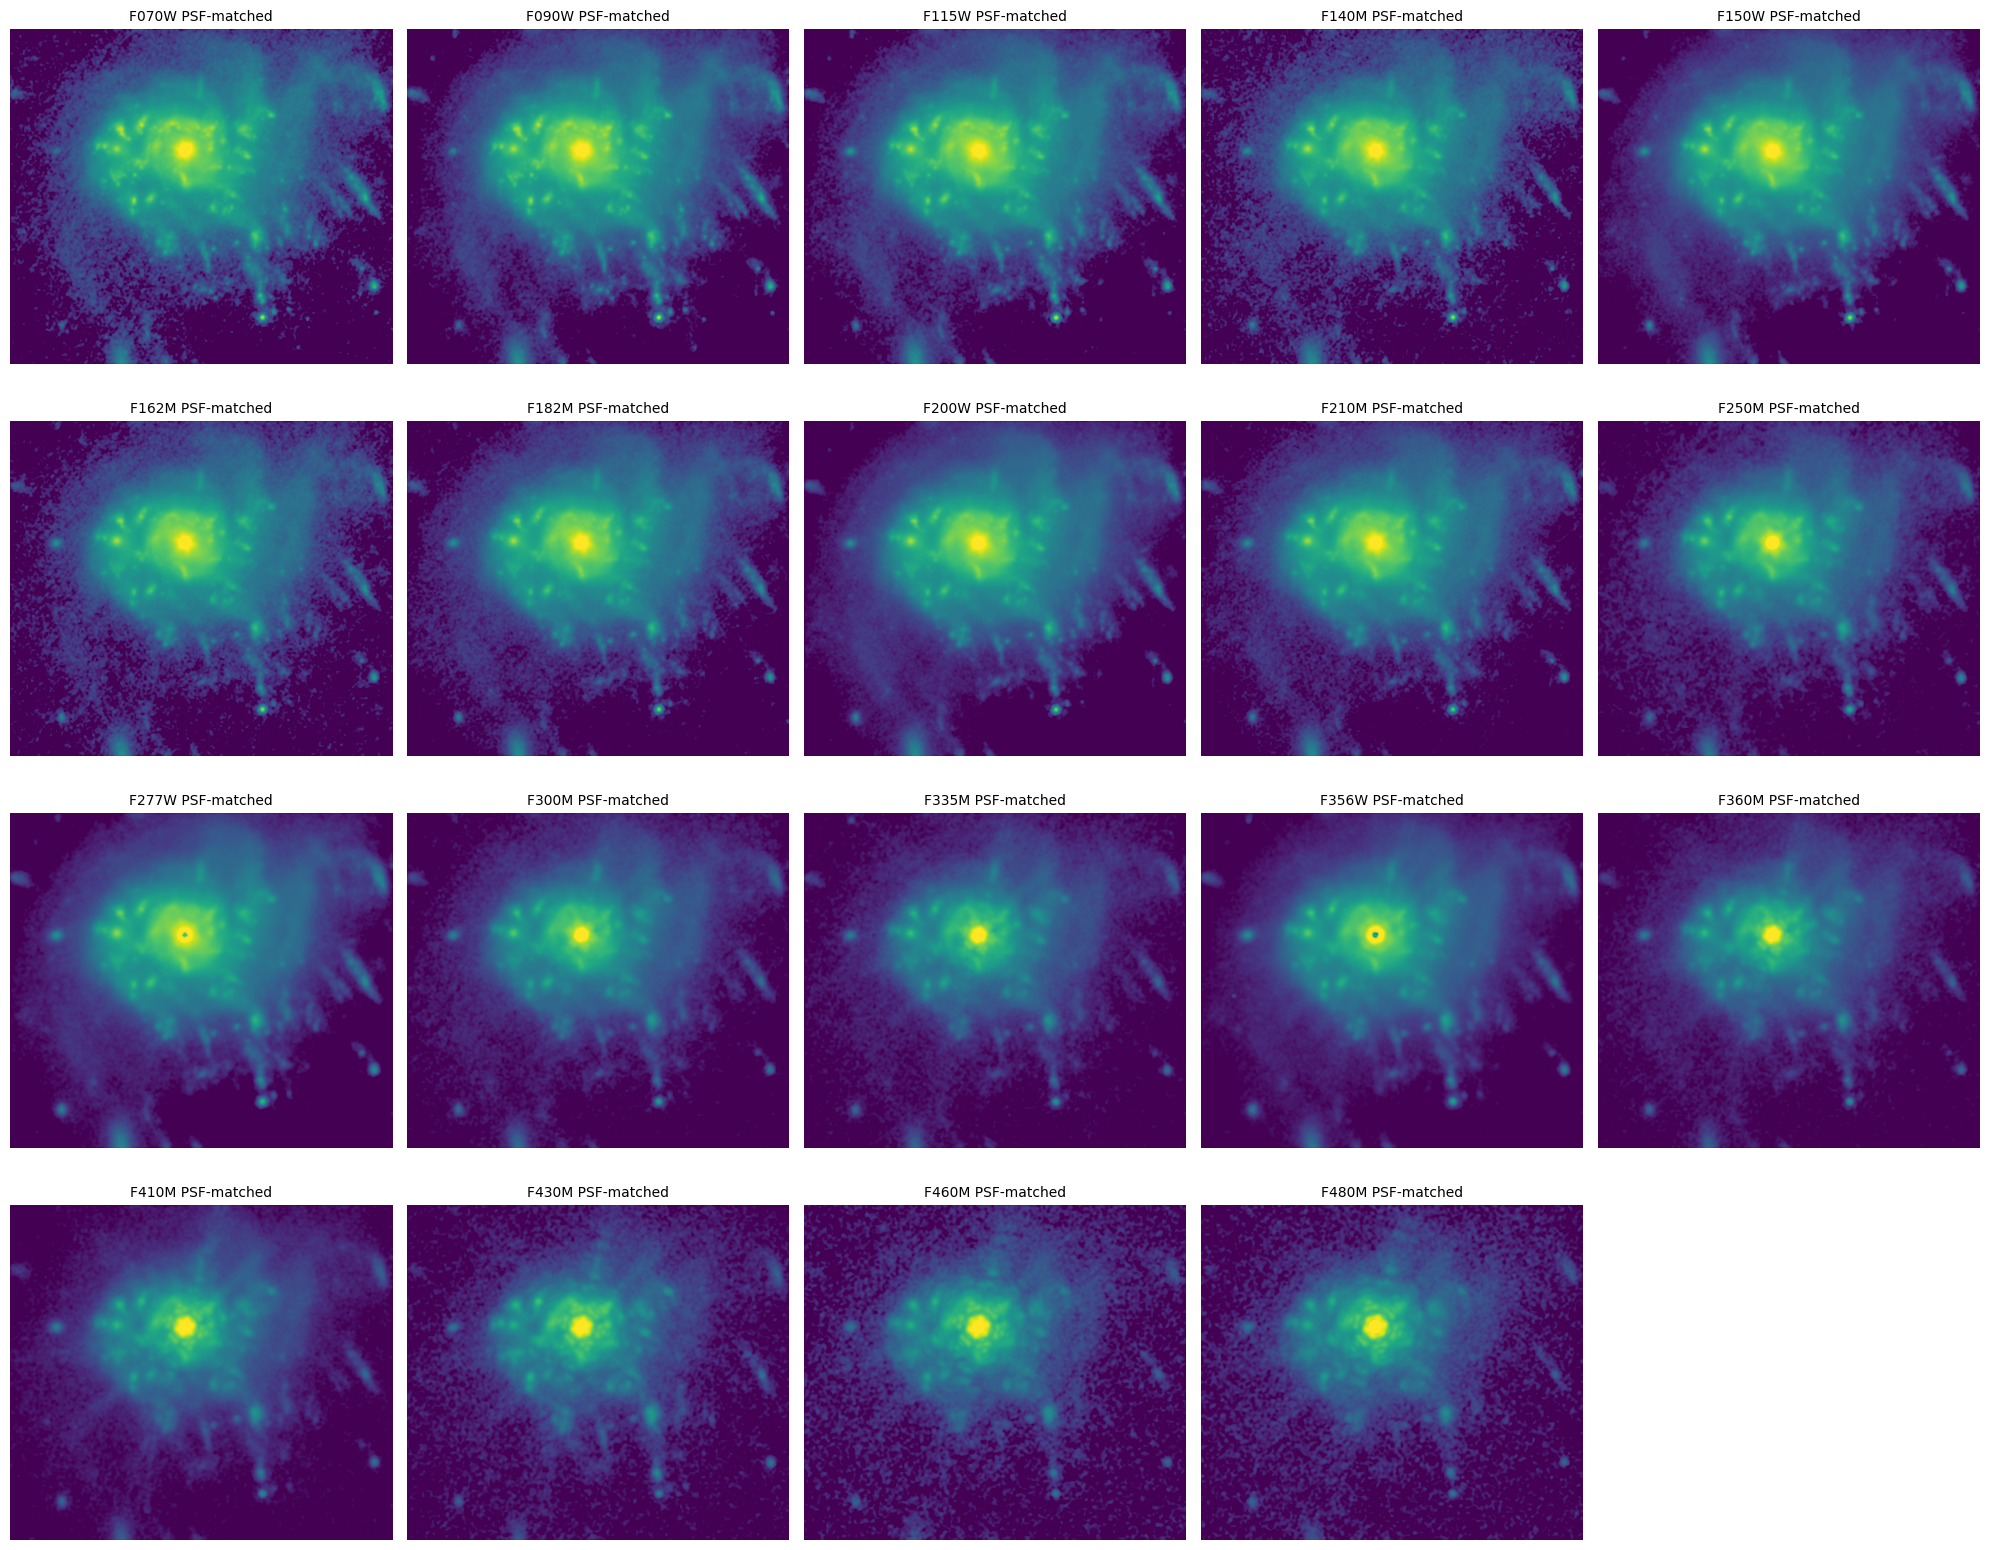

In [15]:
psfmatched_files = sorted(glob.glob(os.path.join(path_fits, "*_psfmatched.fits")))

n = len(psfmatched_files)
ncols = 5
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
axes = axes.flatten()

for ax, fpath in zip(axes, psfmatched_files):

    with fits.open(fpath) as hdul:
        data = hdul[0].data

    fname = os.path.basename(fpath)
    filt = get_filter(fname)

    norm = simple_norm(data, stretch="log", min_percent=25., max_percent=99.9)

    im = ax.imshow(data, origin="lower", cmap="viridis", norm=norm)
    ax.set_title(f"{filt} PSF-matched", fontsize=10)
    ax.axis("off")

for j in range(len(psfmatched_files), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Compare original PSFs (first plot of this notebook) with convolved PSFs:

Original PSF sum: 1.0011626884207785
Matched PSF sum: 1.0005587922332002
Original PSF sum: 0.9849380630340975
Matched PSF sum: 0.9843291578655452
Original PSF sum: 0.9840411254047545
Matched PSF sum: 0.9834155827343981
Original PSF sum: 1.000837285148018
Matched PSF sum: 1.0002530742224458
Original PSF sum: 0.9824782975222823
Matched PSF sum: 0.981878841819842
Original PSF sum: 1.0011833432424704
Matched PSF sum: 1.0005989548363048
Original PSF sum: 1.0016826129974488
Matched PSF sum: 1.0010949669951807
Original PSF sum: 0.9797839406584157
Matched PSF sum: 0.979196494692228
Original PSF sum: 1.0022957412964535
Matched PSF sum: 1.0017168626258754
Original PSF sum: 1.003037164791465
Matched PSF sum: 1.0026286096000117
Original PSF sum: 0.9724951654274211
Matched PSF sum: 0.9721571653263016
Original PSF sum: 1.0037916294299116
Matched PSF sum: 1.0034013797700911
Original PSF sum: 1.0042640205428621
Matched PSF sum: 1.0039990459388128
Original PSF sum: 0.9650016662108564
Matched PSF sum: 0

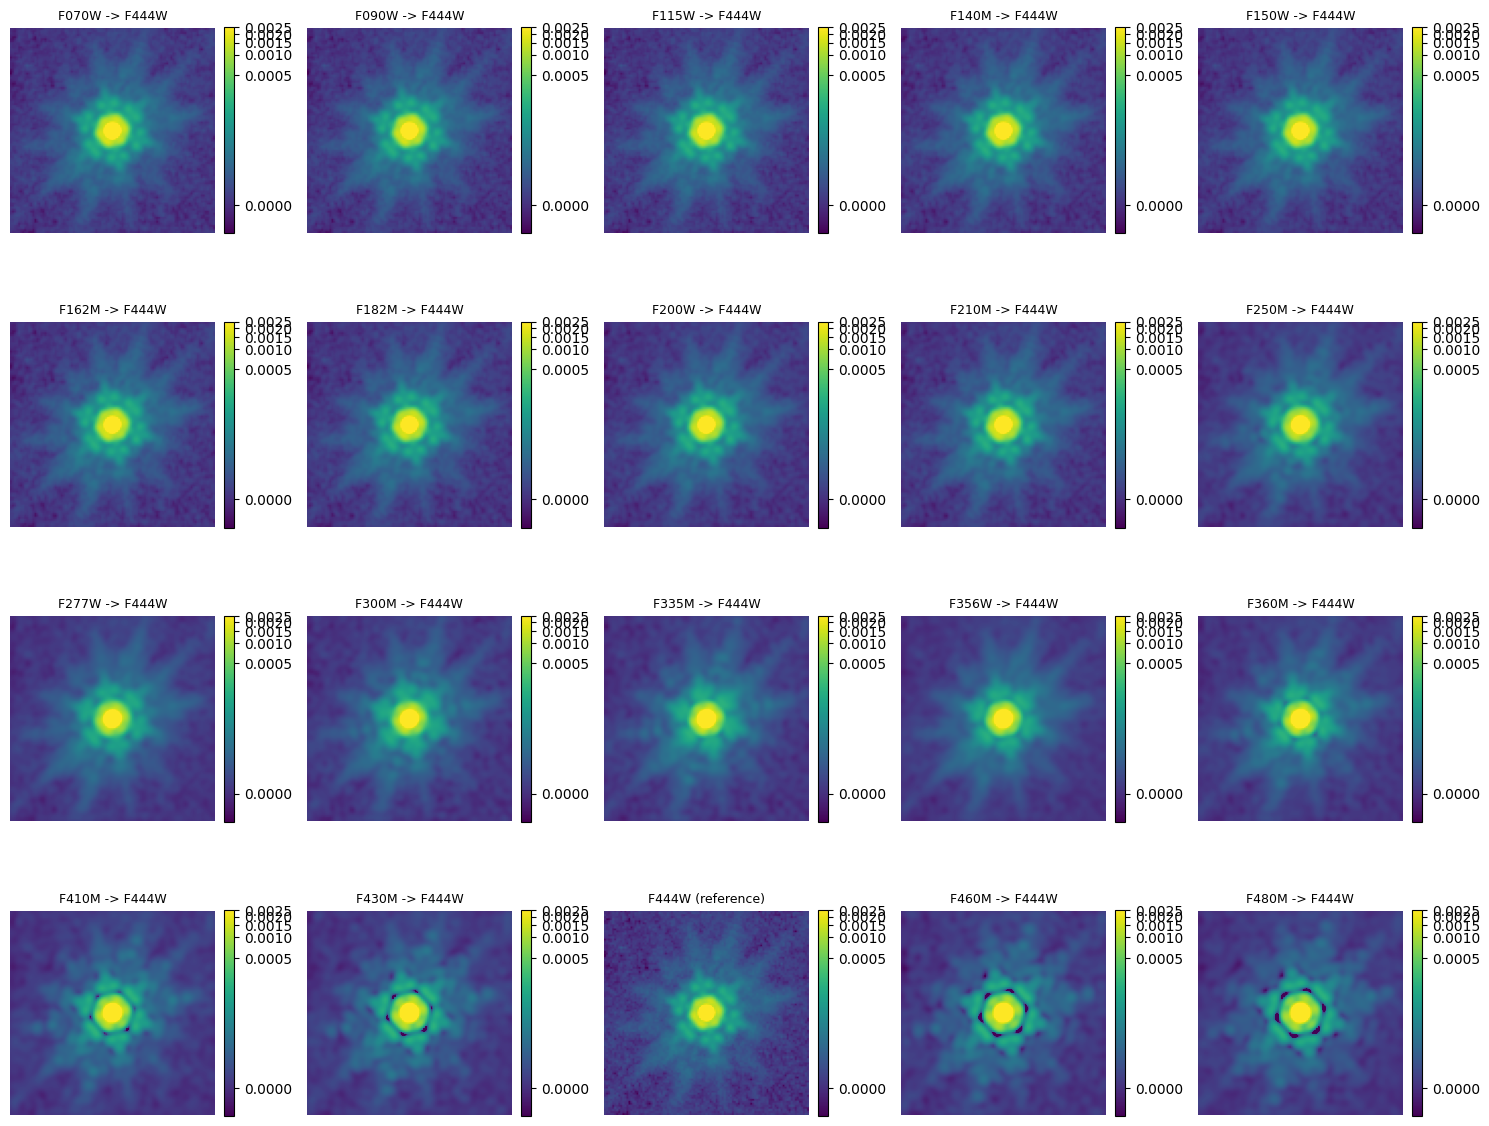

In [19]:
psf_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst"
psf_files = sorted(glob.glob(f"{psf_dir}/*.fits"))

kernel_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft"

ref_filter = "F444W"

ncols = 5
nrows = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))
axes = axes.flatten()

i = 0
for psf_file in psf_files:
    fname = os.path.basename(psf_file)
    filt = get_filter(fname)

    psf_source = fits.getdata(psf_file).astype(float)

    if filt.upper() == ref_filter:
        psf_matched = psf_source
        title = f"{filt} (reference)"
    else:
        kernel_path = os.path.join(
            kernel_dir, f"kernel_{filt.lower()}_to_{ref_filter.lower()}.fits")

        if not os.path.exists(kernel_path):
            print(f"Kernel not found for {filt}, skipping.")
            continue

        kernel = fits.getdata(kernel_path).astype(float)

        psf_matched = convolve_fft(psf_source, kernel, normalize_kernel=True, allow_huge=True)
        title = f"{filt} -> {ref_filter}"

        print("Original PSF sum:", np.sum(psf_source)) #just to check, you can comment this part. If ~1, everything is okay!
        print("Matched PSF sum:", np.sum(psf_matched))
    
    ax = axes[i]

    norm1 = simple_norm(psf_data, "log", percent=99.)
    # norm_mask = np.logical_or(np.isnan(psf_data), psf_data <= 0.)
    # norm2 = simple_norm(psf_data[~norm_mask], stretch="log", min_percent=25.,
    #                     max_percent=99.98)
    im = ax.imshow(psf_matched, norm=norm1, origin="lower", cmap="viridis")
    ax.set_title(title, fontsize=9)
    ax.axis("off")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    i += 1

for j in range(i, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

PSF matching in datacubes

In [23]:
cube_path = "/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/datacube_nircam.fits"
out_cube = cube_path.replace(".fits", "_psfmatched.fits")

kernel_dir = "/home/andressa/Doutorado/Pesquisa/clumps_general/inputs/data_psf_abell2744/psfs_abell2744_uncover/jwst/kernels_fft"

with fits.open(cube_path) as hdul:
    cube = hdul[0].data
    header = hdul[0].header

nfilters, ny, nx = cube.shape
cube_conv = np.zeros_like(cube)

for i in range(nfilters):
    filt = header.get(f"FILTER{i+1}")
    filt = filt.strip()
    filt_lower = filt.lower()

    print(f"Processing slice {i+1}/{nfilters}: {filt}")

    if filt.upper() == "F444W":
        cube_conv[i] = cube[i]
        continue

    kernel_path = os.path.join(
        kernel_dir, f"kernel_{filt_lower}_to_f444w.fits"
    )

    if not os.path.exists(kernel_path):
        print(f"Kernel not found for {filt}, skipping slice.")
        cube_conv[i] = cube[i]
        continue

    kernel = fits.getdata(kernel_path)

    cube_conv[i] = apply_kernel(cube[i], kernel)

fits.PrimaryHDU(cube_conv, header=header).writeto(out_cube, overwrite=True)
print(f"PSF-matched datacube saved at {out_cube}")

Processing slice 1/20: F070W
Processing slice 2/20: F090W
Processing slice 3/20: F115W
Processing slice 4/20: F140M
Processing slice 5/20: F150W
Processing slice 6/20: F162M
Processing slice 7/20: F182M
Processing slice 8/20: F200W
Processing slice 9/20: F210M
Processing slice 10/20: F250M
Processing slice 11/20: F277W
Processing slice 12/20: F300M
Processing slice 13/20: F335M
Processing slice 14/20: F356W
Processing slice 15/20: F360M
Processing slice 16/20: F410M
Processing slice 17/20: F430M
Processing slice 18/20: F444W
Processing slice 19/20: F460M
Processing slice 20/20: F480M
PSF-matched datacube saved at /home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/datacube_nircam_psfmatched.fits


Number of filters: 20


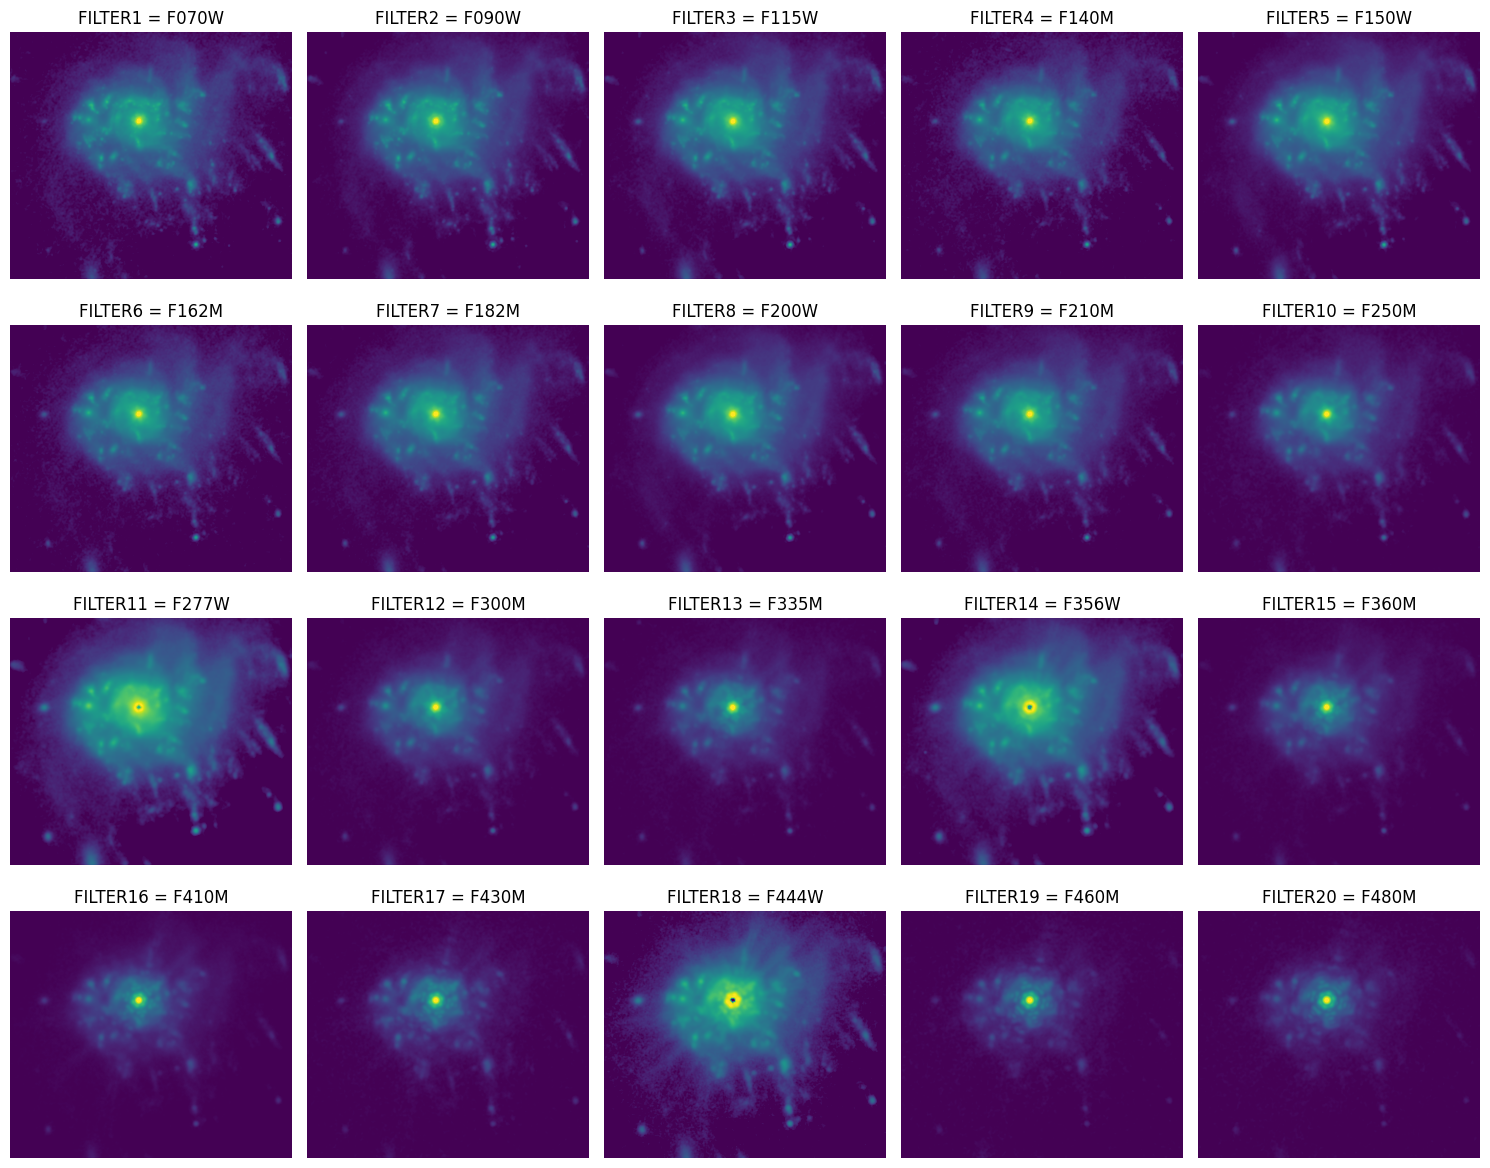

In [28]:
datacube_file = "/home/andressa/Doutorado/Pesquisa/clumps_general/outputs/datacubes/region_1/NIRCam/datacube_nircam_psfmatched.fits"

with fits.open(datacube_file) as hdul:
    datacube = hdul[0].data     
    header = hdul[0].header
    
n_filters = datacube.shape[0]
print(f'Number of filters: {n_filters}')
filters = [header[f"FILTER{i+1}"] for i in range(n_filters)]

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    data = datacube[i, :, :]

    mask = np.logical_or(np.isnan(data), data <= 0.)
    norm = simple_norm(data[~mask], stretch='log',
                       min_percent=25., max_percent=99.98)
    
    ax.imshow(data, origin='lower', cmap='viridis', norm=norm)
    ax.set_title(f'FILTER{i+1} = {filters[i]}')
    ax.axis("off")

for j in range(n_filters, len(axes)):
    axes[j].axis("off")
    
plt.tight_layout()
plt.show()
#plt.savefig('path_to_save.png', dpi=200)